## $\textbf{Tea Flow Modelling}$

In [1]:
# Import required libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal, uniform
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import ultranest

### $\textbf{1. Data Pre-Processing}$

#### $\textbf{1.1 Microscope Data}$

In [2]:
# Read in the classified microscope data.
microscope = pd.read_csv("../datasets/microscope-data/microscope-classified.csv")

# View the data.
print(microscope.head().to_markdown())

|    |   surface-tension |   contact-angle |   dynamic-viscosity |   travel-distance |   dunking-time |   pore-radius | biscuit   |
|---:|------------------:|----------------:|--------------------:|------------------:|---------------:|--------------:|:----------|
|  0 |         0.0845956 |         1.55737 |         0.000981483 |       0.00322055  |        24.2311 |   7.45371e-07 | Hobnob    |
|  1 |         0.0642912 |         1.53884 |         0.000997503 |       0.00239506  |        22.1698 |   2.60068e-07 | Rich Tea  |
|  2 |         0.0862236 |         1.54614 |         0.00100762  |       0.00303645  |        23.2577 |   3.73462e-07 | Rich Tea  |
|  3 |         0.0828591 |         1.56688 |         0.000997457 |       0.00126069  |        12.7174 |   7.56717e-07 | Rich Tea  |
|  4 |         0.0908324 |         1.57023 |         0.00100171  |       0.000576075 |        15.1891 |   8.23907e-07 | Rich Tea  |


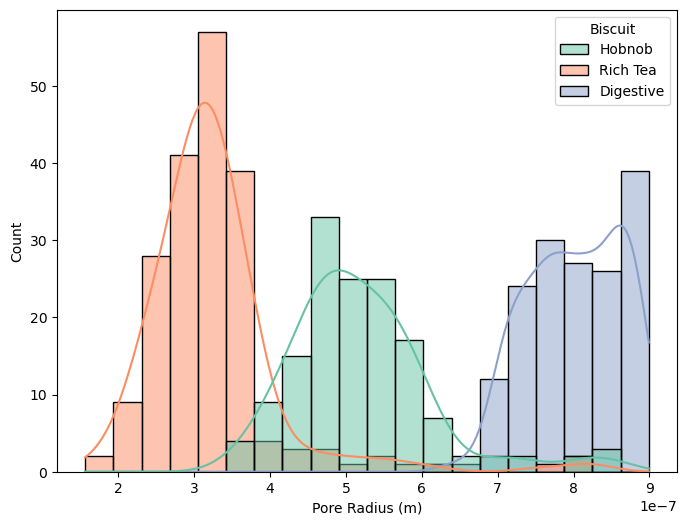

In [3]:
# Plot the distribution of pore-radius values.
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data.
sns.histplot(data=microscope, 
             x="pore-radius",
             hue="biscuit",
             bins=20,
             kde=True, 
             palette="Set2",  
             ax=ax)

# Set the labels.
ax.set_xlabel("Pore Radius (m)")
ax.set_ylabel("Count")

# Set the legend.
ax.get_legend().set_title("Biscuit")

plt.show()

In [4]:
# Calculate the average pore-radius for each biscuit.
pore_radius_mean = microscope.groupby("biscuit")["pore-radius"].mean()
print(pore_radius_mean)

biscuit
Digestive    8.017095e-07
Hobnob       5.204008e-07
Rich Tea     3.246948e-07
Name: pore-radius, dtype: float64


In [5]:
# Calculate the standard deviation in the pore-radius for each biscuit.
pore_radius_std = microscope.groupby("biscuit")["pore-radius"].std()
print(pore_radius_std)

biscuit
Digestive    6.104804e-08
Hobnob       9.277268e-08
Rich Tea     8.886276e-08
Name: pore-radius, dtype: float64


#### $\textbf{1.2 Time Series Data}$

In [6]:
# Read in the time series data.
time_series_1 = pd.read_csv("../datasets/time-series-data/time-series-1.csv")
time_series_2 = pd.read_csv("../datasets/time-series-data/time-series-2.csv")
time_series_3 = pd.read_csv("../datasets/time-series-data/time-series-3.csv")

# View the 1st time series data.
print(time_series_1.head().to_markdown())

|    |   dunking-time |   travel-distance |   travel-distance-error |
|---:|---------------:|------------------:|------------------------:|
|  0 |        30      |        0.00808733 |             0.000392256 |
|  1 |        32.7273 |        0.00825305 |             0.000270256 |
|  2 |        35.4545 |        0.00860703 |             0.000500771 |
|  3 |        38.1818 |        0.00892041 |             0.000266705 |
|  4 |        40.9091 |        0.00960407 |             0.000273968 |


### $\textbf{2. Microscope Data Regression}$

#### $\textbf{2.1 Data Pre-Processing}$

In [7]:
# Split the microscope data into features and targets.
micro_features = microscope.drop(["biscuit", "travel-distance"], axis="columns")
micro_targets = microscope["travel-distance"]

#### $\textbf{2.2 Washburn Equation}$

$$
L = \sqrt{\frac{\gamma r t \cos(\phi)}{2 \eta}}
$$

In [8]:
def washburn(gamma: float, eta: float, phi: float, radius: float, time: float) -> float:
    """
    Calculates the Washburn equation for a given set of gamma, eta, phi, radius 
    and time values. The Washburn equation models the flow of a liquid up an 
    object due to capillary flow.

    Parameters
    ----------
    gamma : float
        The surface tension of the liquid.

    eta : float
        The dynamic viscosity of the liquid.

    phi : float
        The contact angle between the object and the liquid.

    radius : float
        The pore radius of the object.

    time : float
        The amount of time the object is submerged in the liquid.

    Returns
    -------
    float
        The travel distance of the liquid up the object.
    """

    return np.sqrt((gamma * radius * time * np.cos(phi)) / (2 * eta))

In [9]:
# Predict the travel-distance using the Washburn model on the microscope data.
washburn_micro_predicted = washburn(microscope["surface-tension"], 
                                    microscope["dynamic-viscosity"],
                                    microscope["contact-angle"],
                                    microscope["pore-radius"],
                                    microscope["dunking-time"])

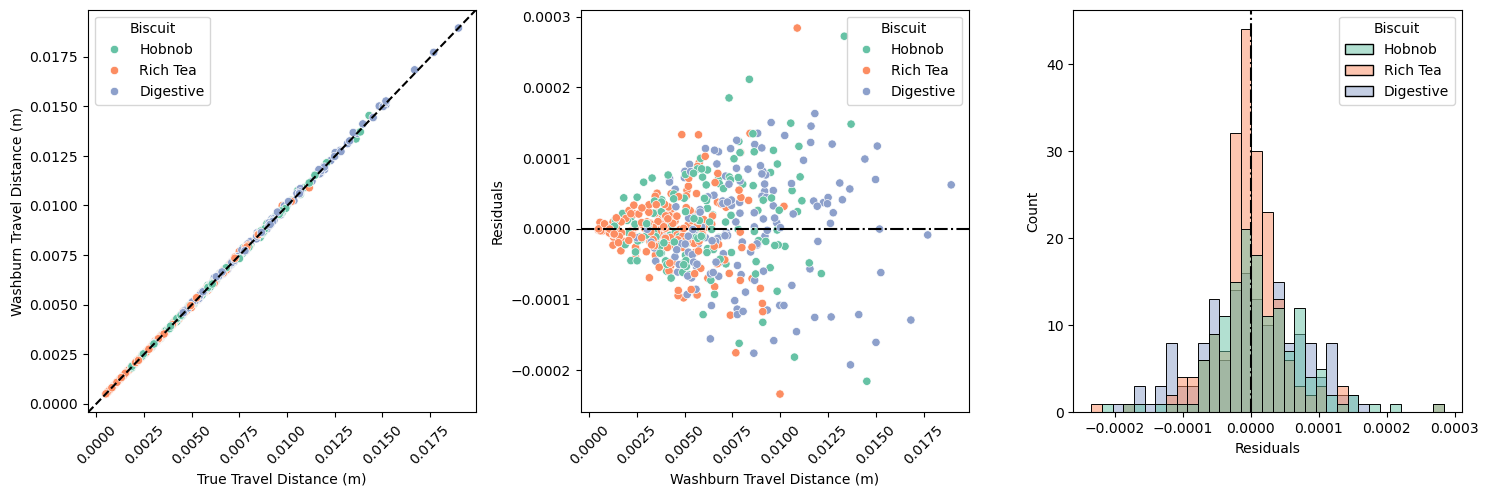

In [10]:
# Visualise the performance of the Washburn model.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the residuals of the predicted travel-distance values.
washburn_micro_residuals = micro_targets - washburn_micro_predicted

# Plot the predicted travel-distance values against the true travel-distance values.
sns.scatterplot(data=microscope,
                x="travel-distance",
                y=washburn_micro_predicted,
                hue="biscuit",
                palette="Set2",
                ax=ax[0])

# Plot the residuals.
sns.scatterplot(data=microscope,
                x=washburn_micro_predicted,
                y=washburn_micro_residuals,
                hue="biscuit",
                palette="Set2",
                ax=ax[1])

# Plot the distribution of the residuals.
sns.histplot(data=microscope,
             x=washburn_micro_residuals,
             hue="biscuit",
             palette="Set2",
             ax=ax[2])

## Customise the 1st plot.
# Plot a "theoretical best" line.
ax[0].plot([0, 1], [0, 1], 
           transform=ax[0].transAxes,
           linestyle="--",
           color="k")

# Set the labels.
ax[0].set_xlabel("True Travel Distance (m)")
ax[0].set_ylabel("Washburn Travel Distance (m)")
ax[0].legend(title="Biscuit")

# Rotate the x-axis ticks.
ax[0].tick_params(axis="x", rotation=45)

## Customise the 2nd plot.
# Plot a "theoretical best" line.
ax[1].axhline(y=0, linestyle="-.", color="k")

# Set the labels.
ax[1].set_xlabel("Washburn Travel Distance (m)")
ax[1].set_ylabel("Residuals")
ax[1].legend(title="Biscuit")

# Rotate the x-axis ticks.
ax[1].tick_params(axis="x", rotation=45)

## Customise the 3rd plot.
# Plot a "theoretical best" line.
ax[2].axvline(x=0, linestyle="-.", color="k")

# Set the labels.
ax[2].set_xlabel("Residuals")
ax[2].set_ylabel("Count")
ax[2].get_legend().set_title("Biscuit")

fig.tight_layout()
plt.show()

In [11]:
# Calculate the MAE, MSE and RMSE of the Washburn model.
washburn_micro_mae = mean_absolute_error(micro_targets, washburn_micro_predicted)
washburn_micro_mse = mean_squared_error(micro_targets, washburn_micro_predicted)
washburn_micro_rmse = root_mean_squared_error(micro_targets, washburn_micro_predicted)

# Print the error metrics.
print(f"Washburn MAE    : {washburn_micro_mae:.5e}")
print(f"Washburn MSE    : {washburn_micro_mse:.5e}")
print(f"Washburn RMSE   : {washburn_micro_rmse:.5e}")

Washburn MAE    : 4.63639e-05
Washburn MSE    : 4.14059e-09
Washburn RMSE   : 6.43474e-05


In [12]:
# Calculate the R2 score for the Washburn model.
washburn_micro_r2 = r2_score(micro_targets, washburn_micro_predicted)
print(f"Washburn R2 Score: {washburn_micro_r2:.5f}")

Washburn R2 Score: 0.99959


#### $\textbf{2.3 Random Forest}$

##### $\textbf{2.3.1 Dunking Data Pre-Processing \& Feature Engineering}$

In [13]:
# Read in the dunking data.
dunking = pd.read_csv("../datasets/dunking-data/dunking.csv")

# View the data.
print(dunking.head().to_markdown())

|    |   surface-tension |   contact-angle |   dynamic-viscosity |   travel-distance |   dunking-time | biscuit   |
|---:|------------------:|----------------:|--------------------:|------------------:|---------------:|:----------|
|  0 |         0.0738967 |         1.33301 |         0.000998733 |        0.0111961  |        19.3622 | Digestive |
|  1 |         0.0809462 |         1.47676 |         0.00101176  |        0.00589433 |        11.8526 | Digestive |
|  2 |         0.0874079 |         1.47714 |         0.000983589 |        0.00924863 |        24.7937 | Digestive |
|  3 |         0.070793  |         1.502   |         0.0010016   |        0.00377375 |        16.2928 | Hobnob    |
|  4 |         0.0589175 |         1.54827 |         0.00100433  |        0.00229071 |        13.6623 | Hobnob    |


In [14]:
# Get the number of samples for each biscuit.
print(dunking.groupby("biscuit").count().to_markdown())

| biscuit   |   surface-tension |   contact-angle |   dynamic-viscosity |   travel-distance |   dunking-time |
|:----------|------------------:|----------------:|--------------------:|------------------:|---------------:|
| Digestive |              1000 |            1000 |                1000 |              1000 |           1000 |
| Hobnob    |              1000 |            1000 |                1000 |              1000 |           1000 |
| Rich Tea  |              1000 |            1000 |                1000 |              1000 |           1000 |


In [15]:
# Generate and store normal distributed pore-radius values for the Digestive biscuit.
digestive_pore_radii = np.random.normal(pore_radius_mean["Digestive"], pore_radius_std["Digestive"], 1000)
dunking.loc[dunking["biscuit"] == "Digestive", "pore-radius"] = digestive_pore_radii

# Generate and store normal distributed pore-radius values for the Hobnob biscuit.
hobnob_pore_radii = np.random.normal(pore_radius_mean["Hobnob"], pore_radius_std["Hobnob"], 1000)
dunking.loc[dunking["biscuit"] == "Hobnob", "pore-radius"] = hobnob_pore_radii

# Generate and store normal distributed pore-radius values for the Rich Tea biscuit.
rich_tea_pore_radii = np.random.normal(pore_radius_mean["Rich Tea"], pore_radius_std["Rich Tea"], 1000)
dunking.loc[dunking["biscuit"] == "Rich Tea", "pore-radius"] = rich_tea_pore_radii

In [16]:
# Split the dunking data into train and test subsets.
dunk_train, dunk_test = train_test_split(dunking, train_size=0.80, shuffle=True)

# Split the train subset into features and targets.
dunk_train_features = dunk_train.drop(["biscuit", "travel-distance"], axis="columns")
dunk_train_targets = dunk_train["travel-distance"]

# Split the test subset into features and targets.
dunk_test_features = dunk_test.drop(["biscuit", "travel-distance"], axis="columns")
dunk_test_targets = dunk_test["travel-distance"]

##### $\textbf{2.3.2 Initial Model}$


In [17]:
# Create a Random Forest Regressor (RFR) model.
rfr = RandomForestRegressor()

# Train the RFR model.
rfr.fit(dunk_train_features, dunk_train_targets)

# Test the RFR model.
rfr_dunk_predicted = rfr.predict(dunk_test_features)

In [18]:
# Calculate the MAE, MSE and RMSE of the RFR model.
rfr_dunk_mae = mean_absolute_error(dunk_test_targets, rfr_dunk_predicted)
rfr_dunk_mse = mean_squared_error(dunk_test_targets, rfr_dunk_predicted)
rfr_dunk_rmse = root_mean_squared_error(dunk_test_targets, rfr_dunk_predicted)

# Print the error metrics.
print(f"RFR MAE : {rfr_dunk_mae:.5e}")
print(f"RFR MSE : {rfr_dunk_mse:.5e}")
print(f"RFR RMSE: {rfr_dunk_rmse:.5e}")

RFR MAE : 5.40292e-04
RFR MSE : 5.65415e-07
RFR RMSE: 7.51941e-04


In [19]:
# Calculate the R2 score for the RFR model.
rfr_dunk_r2 = r2_score(dunk_test_targets, rfr_dunk_predicted)
print(f"RFR R2 Score: {rfr_dunk_r2:.5f}")

RFR R2 Score: 0.94067


##### $\textbf{2.3.4 Tuned Model}$

In [20]:
# Show the parameters of the RFR model.
display(rfr.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [21]:
# Create a parameter grid to search over.
rfr_param_grid = {
    "max_depth": [10, 25, 50, None],
    "max_features": ["sqrt", None],
    "n_estimators": [100, 150, 200, 250],
}

# Perform a random search over the parameter grid.
rfr_grid = RandomizedSearchCV(estimator=RandomForestRegressor(), 
                              param_distributions=rfr_param_grid, 
                              scoring="r2", 
                              cv=5, 
                              n_iter=25)
rfr_grid.fit(dunk_train_features, dunk_train_targets)

# Print the best found parameters. 
print(f"RFR Best Parameters: {rfr_grid.best_params_}")

# Store the best found rfr model.
rfr_optimal = rfr_grid.best_estimator_

# Test the best found rfr model.
rfr_dunk_predicted = rfr_optimal.predict(dunk_test_features)

RFR Best Parameters: {'n_estimators': 250, 'max_features': None, 'max_depth': 25}


In [22]:
# Calculate the MAE, MSE and RMSE of the RFR model.
rfr_dunk_mae = mean_absolute_error(dunk_test_targets, rfr_dunk_predicted)
rfr_dunk_mse = mean_squared_error(dunk_test_targets, rfr_dunk_predicted)
rfr_dunk_rmse = root_mean_squared_error(dunk_test_targets, rfr_dunk_predicted)

# Print the error metrics.
print(f"RFR MAE : {rfr_dunk_mae:.5e}")
print(f"RFR MSE : {rfr_dunk_mse:.5e}")
print(f"RFR RMSE: {rfr_dunk_rmse:.5e}")

RFR MAE : 5.43234e-04
RFR MSE : 5.64787e-07
RFR RMSE: 7.51523e-04


In [23]:
# Calculate the R2 score for the RFR model.
rfr_dunk_r2 = r2_score(dunk_test_targets, rfr_dunk_predicted)
print(f"RFR R2 Score: {rfr_dunk_r2:.5f}")

RFR R2 Score: 0.94073


##### $\textbf{2.3.5 Microscope Data Regression}$

In [24]:
# Predict the travel-distance using the RFR model on the microscope data.
rfr_micro_predicted = rfr.predict(micro_features)

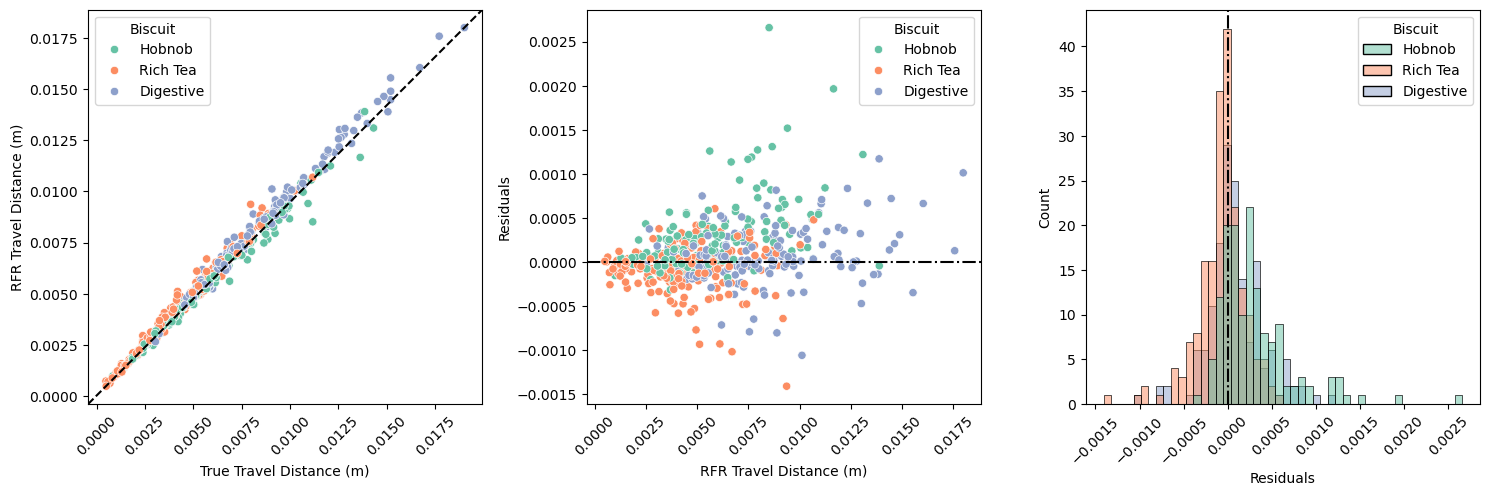

In [25]:
# Visualise the performance of the RFR model.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the residuals of the predicted travel-distance values.
rfr_micro_residuals = micro_targets - rfr_micro_predicted

# Plot the predicted travel-distance values against the true travel-distance values.
sns.scatterplot(data=microscope,
                x="travel-distance",
                y=rfr_micro_predicted,
                hue="biscuit",
                palette="Set2",
                ax=ax[0])

# Plot the residuals.
sns.scatterplot(data=microscope,
                x=rfr_micro_predicted,
                y=rfr_micro_residuals,
                hue="biscuit",
                palette="Set2",
                ax=ax[1])

# Plot the distribution of the residuals.
sns.histplot(data=microscope,
             x=rfr_micro_residuals,
             hue="biscuit",
             palette="Set2",
             ax=ax[2])

## Customise the 1st plot.
# Plot a "theoretical best" line.
ax[0].plot([0, 1], [0, 1], 
           transform=ax[0].transAxes,
           linestyle="--",
           color="k")

# Set the labels.
ax[0].set_xlabel("True Travel Distance (m)")
ax[0].set_ylabel("RFR Travel Distance (m)")
ax[0].legend(title="Biscuit")

# Rotate the x-axis ticks.
ax[0].tick_params(axis="x", rotation=45)

## Customise the 2nd plot.
# Plot a "theoretical best" line.
ax[1].axhline(y=0, linestyle="-.", color="k")

# Set the labels.
ax[1].set_xlabel("RFR Travel Distance (m)")
ax[1].set_ylabel("Residuals")
ax[1].legend(title="Biscuit")

# Rotate the x-axis ticks.
ax[1].tick_params(axis="x", rotation=45)

## Customise the 3rd plot.
# Plot a "theoretical best" line.
ax[2].axvline(x=0, linestyle="-.", color="k")

# Set the labels.
ax[2].set_xlabel("Residuals")
ax[2].set_ylabel("Count")
ax[2].get_legend().set_title("Biscuit")

# Rotate the x-axis ticks.
ax[2].tick_params(axis="x", rotation=45)

fig.tight_layout()
plt.show()

In [26]:
# Calculate the MAE, MSE and RMSE of the RFR model.
rfr_micro_mae = mean_absolute_error(micro_targets, rfr_micro_predicted)
rfr_micro_mse = mean_squared_error(micro_targets, rfr_micro_predicted)
rfr_micro_rmse = root_mean_squared_error(micro_targets, rfr_micro_predicted)

# Print the error metrics.
print(f"RFR MAE : {rfr_micro_mae:.5e}")
print(f"RFR MSE : {rfr_micro_mse:.5e}")
print(f"RFR RMSE: {rfr_micro_rmse:.5e}")

RFR MAE : 2.46235e-04
RFR MSE : 1.42348e-07
RFR RMSE: 3.77290e-04


In [27]:
# Calculate the R2 score for the RFR model.
rfr_micro_r2 = r2_score(micro_targets, rfr_micro_predicted)
print(f"RFR R2 Score: {rfr_micro_r2:.5f}")

RFR R2 Score: 0.98590


#### $\textbf{2.4 Model Comparison}$

##### $\textbf{2.4.1 Error Metrics - MAE, MSE \& RMSE}$

In [28]:
# Print the error metrics for the Washburn model.
print(f"Washburn MAE    : {washburn_micro_mae:.5e}")
print(f"Washburn MSE    : {washburn_micro_mse:.5e}")
print(f"Washburn RMSE   : {washburn_micro_rmse:.5e}")

Washburn MAE    : 4.63639e-05
Washburn MSE    : 4.14059e-09
Washburn RMSE   : 6.43474e-05


In [29]:
# Print the error metrics for the RFR model.
print(f"RFR MAE : {rfr_micro_mae:.5e}")
print(f"RFR MSE : {rfr_micro_mse:.5e}")
print(f"RFR RMSE: {rfr_micro_rmse:.5e}")

RFR MAE : 2.46235e-04
RFR MSE : 1.42348e-07
RFR RMSE: 3.77290e-04


##### $\textbf{2.4.2 R2 Score}$

In [30]:
# Print the R2 score for the different models.
print(f"Washburn R2 Score: {washburn_micro_r2:.5f}")
print(f"RFR R2 Score: {rfr_micro_r2:.5f}")

Washburn R2 Score: 0.99959
RFR R2 Score: 0.98590


##### $\textbf{2.4.3 Extra - Feature Importance}$

In [31]:
# Print the importance of features from the RFR model.
for feature, importance in zip(rfr_optimal.feature_names_in_, rfr_optimal.feature_importances_):
    # Account for formatting.
    if feature != "dynamic-viscosity":
        print(f"{feature}\t\t: {importance:.5f}")
    else:
        print(f"{feature}\t: {importance:.5f}")

surface-tension		: 0.02407
contact-angle		: 0.68315
dynamic-viscosity	: 0.00744
dunking-time		: 0.10976
pore-radius		: 0.17558


### $\textbf{3. Time Series Data Modelling}$

#### $\textbf{3.1 Data Constants}$

+ $\text{Surface Tension} \; (\gamma) = 6.78 \times 10^{-2} \; \text{Nm}^{-1}$
+ $\text{Dynamic Viscosity} \; (\eta) = 9.93 \times 10^{-4} \; \text{Pa s}$

- $\text{Contact Angle} \; (\phi) = 1.45 \; \text{rad}$

In [32]:
# Define the independent variable values.
ts_dynamic_viscosity = 9.93e-4
ts_surface_tension = 6.78e-2
ts_contact_angle = 1.45

#### $\textbf{3.2 Washburn Equation}$

$$
L = \sqrt{\frac{\gamma r t \cos(\phi)}{2 \eta}}
$$

In [33]:
def washburn_ts(radius: float, time: float) -> float:
    """
    Calculates the Washburn equation for a given time and radius. The rest of 
    the variables in the equation are set to the values below. This function is 
    intended to be used for the time series data.

    + Surface Tension   (gamma) : 6.78 x 10^{-2} N m^{-1}
    + Dynamic Viscosity (eta)   : 9.93 x 10^{-4} Pa s 
    + Contact Angle     (phi)   : 1.45 rad

    Parameters
    ----------
    radius : float
        The pore radius of the object.

    time : float
        The amount of time the object is submerged in the liquid.
    
    Returns
    -------
    float
        The travel distance of the liquid up the object.
    """

    # Calculate the numerator and denominator.
    numerator = ts_surface_tension * radius * time * np.cos(ts_contact_angle)
    denominator = 2 * ts_dynamic_viscosity

    return np.sqrt(numerator / denominator)

#### $\textbf{3.3 Modified Washburn Equation}$

$$
L = \alpha \sqrt{\frac{\gamma r t \cos(\phi)}{2 \eta}} + \beta
$$

In [34]:
def washburn_modified_ts(alpha: float, beta: float, radius: float, time: float) -> float:
    """
    Calculates the modified Washburn equation for a given radius, time, alpha 
    and beta. This function uses the normal Washburn equation and is intended 
    to be used for the time series data.

    Parameters
    ----------
    alpha : float
        The scaling constant of the modified Washburn equation.

    beta : float
        The offset constant of the modified Washburn equation.

    radius : float
        The pore radius of the object.

    time : float
        The amount of time the object is submerged in the liquid.
    
    Returns
    -------
    float
        The travel distance of the liquid up the object.
    """

    return (alpha * washburn_ts(radius, time)) + beta

#### $\textbf{3.4 Plotting \& Metric Functions}$

In [35]:
def comparison_plot(time_series: pd.DataFrame, predicted: np.ndarray, labels: list) -> None:
    """
    Generates a plot of both the true and predicted travel-distance values 
    against the dunking-time.
    
    Parameters
    ----------
    time_series : pandas.DataFrame
        The time series data containing the true travel-distance values.

    predicted : np.ndarray
        The predicted travel-distance values.

        
    labels : list
        The labels for the true and predicted curves.
    """

    # Plot the predicted and true travel-distance values.
    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot the true travel-distance values.
    ax.plot(time_series["dunking-time"],
            time_series["travel-distance"],
            color="royalblue",
            label=labels[0])

    # Plot the errors in the true travel-distance values.
    ax.fill_between(time_series["dunking-time"], 
                    time_series["travel-distance"] - time_series["travel-distance-error"],
                    time_series["travel-distance"] + time_series["travel-distance-error"],
                    color="royalblue",
                    alpha=0.25)

    # Plot the predicted travel-distance values.
    ax.plot(time_series["dunking-time"],
            predicted,
            linestyle=":",
            color="k",
            label=labels[1])

    # Set the labels.
    ax.set_xlabel("Dunking Time (s)")
    ax.set_ylabel("Travel Distance (m)")

    # Set the legend.
    ax.legend()

    plt.show()

In [36]:
def performance_plot(time_series: pd.DataFrame, predicted: np.ndarray, label: str) -> None:
    """
    Creates a set of plots which give a visual indicator of the performance of 
    a model. The following plots are generated for the true and predicted 
    travel-distance values.

    + Predicted vs True
    + Residuals vs Predicted
    + Residuals Distribution

    Parameters
    ----------
    time_series : pandas.DataFrame
        The time series data containing the true travel-distance values.

    predicted : np.ndarray
        The predicted travel-distance values.

    label : str
        The axis label to give the predicted travel-distance values.
    """

    # Visualise the performance of the model.
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Calculate the residuals of the predicted travel-distance values.
    residuals = time_series["travel-distance"] - predicted

    # Plot the predicted travel-distance values against the true travel-distance values.
    sns.scatterplot(x=time_series["travel-distance"],
                    y=predicted,
                    color="royalblue",
                    ax=ax[0])

    # Plot the residuals.
    sns.scatterplot(x=predicted,
                    y=residuals,
                    color="crimson",
                    ax=ax[1])

    # Plot the distribution of the residuals.
    sns.histplot(x=residuals,
                 bins=20,
                 color="rebeccapurple",
                 ax=ax[2])

    ## Customise the 1st plot.
    # Plot a "theoretical best" line.
    ax[0].plot([0, 1], [0, 1], 
               transform=ax[0].transAxes,
               linestyle="-.",
               color="k")
    
    # Calculate the lower and upper limits of the axes.
    lower_lim = min(min(time_series["travel-distance"]), min(predicted))
    upper_lim = max(max(time_series["travel-distance"]), max(predicted))

    # Add some padding.
    lower_lim -= (upper_lim - lower_lim) * 0.05
    upper_lim += (upper_lim - lower_lim) * 0.05
    
    # Set the lower and upper limits of the axes.
    ax[0].set_xlim(lower_lim, upper_lim)
    ax[0].set_ylim(lower_lim, upper_lim)

    # Set the labels.
    ax[0].set_xlabel("True Travel Distance (m)")
    ax[0].set_ylabel(label)

    # Rotate the x-axis ticks.
    ax[0].tick_params(axis="x", rotation=45)

    ## Customise the 2nd plot.
    # Plot a "theoretical best" line.
    ax[1].axhline(y=0, linestyle="--", color="k")

    # Set the labels.
    ax[1].set_xlabel(label)
    ax[1].set_ylabel("Residuals")

    # Rotate the x-axis ticks.
    ax[1].tick_params(axis="x", rotation=45)

    ## Customise the 3rd plot.
    # Plot a "theoretical best" line.
    ax[2].axvline(x=0, linestyle="-.", color="k")

    # Set the labels.
    ax[2].set_xlabel("Residuals")
    ax[2].set_ylabel("Count")

    # Rotate the x-axis ticks.
    ax[2].tick_params(axis="x", rotation=45)

    fig.tight_layout()
    plt.show()

In [37]:
def error_metrics(true: np.ndarray, predicted: np.ndarray) -> tuple[float]:
    """
    Calculates the MAE, MSE and RMSE for a set of true and predicted values.

    Parameters
    ----------
    true : np.ndarray
        The true target values.

    predicted : np.ndarray
        The predicted target values.

    Returns
    -------
    mae, mse, rmse : tuple[float]
        A tuple containing the MAE, MSE and RMSE.
    """

    # Calculate the MAE, MSE and RMSE of the true and predicted values.
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = root_mean_squared_error(true, predicted)

    return mae, mse, rmse

#### $\textbf{3.5 Time Series Data 1 - Hobnob Biscuit}$

##### $\textbf{3.5.1 Data Modelling}$

In [38]:
# Create a diagonal covariance matrix.
ts_1_covariance = np.diag(time_series_1["travel-distance-error"] ** 2)

# Generate a multivariate normal distribution.
ts_1_mvn = multivariate_normal(time_series_1["travel-distance"], ts_1_covariance)

##### $\textbf{3.5.2 Washburn Model}$

In [39]:
# Predict the travel-distance using the Washburn model.
washburn_ts_1_predicted = washburn_ts(pore_radius_mean["Hobnob"], time_series_1["dunking-time"])

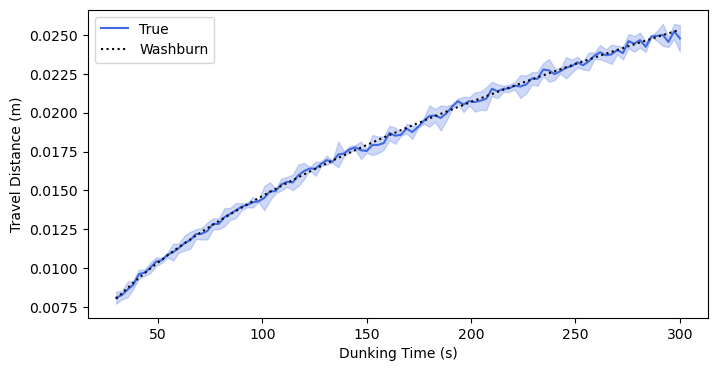

In [40]:
# Visualise the fit of the Washburn model.
comparison_plot(time_series_1, washburn_ts_1_predicted, ("True", "Washburn"))

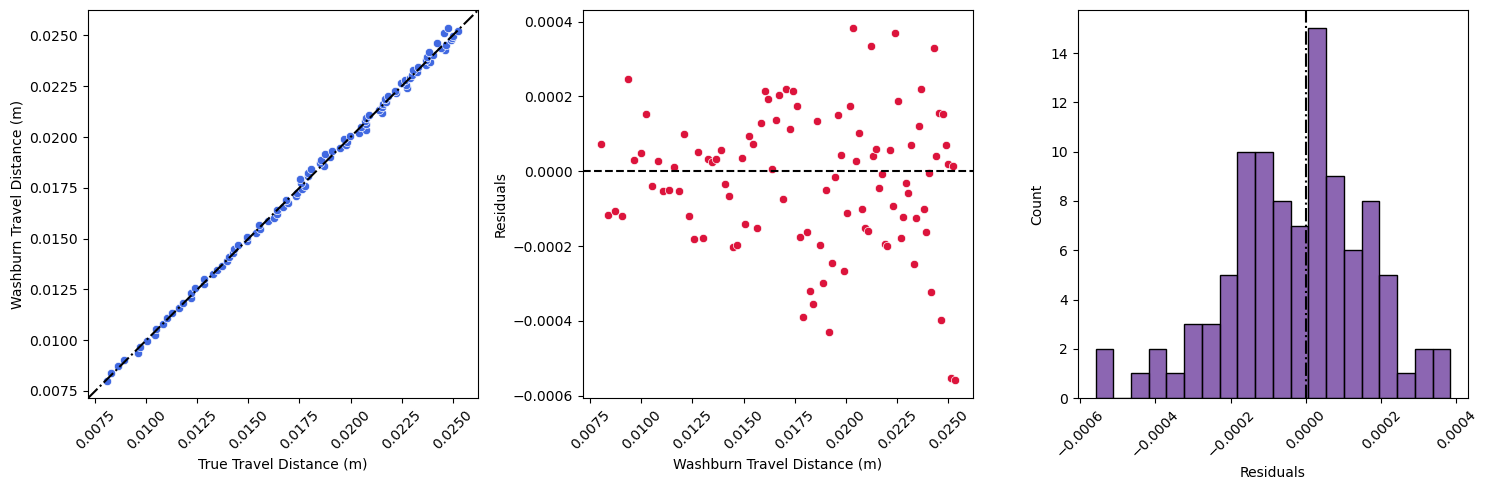

In [41]:
# Visualise the performance of the Washburn model.
performance_plot(time_series_1, washburn_ts_1_predicted, "Washburn Travel Distance (m)")

In [42]:
# Calculate the log-likelihood of the Washburn model.
washburn_ts_1_log_likelihood = ts_1_mvn.logpdf(washburn_ts_1_predicted)
print(f"Washburn TS-1 Log-Likelihood: {washburn_ts_1_log_likelihood}")

Washburn TS-1 Log-Likelihood: 654.4962107793549


In [43]:
# Calculate the MAE, MSE and RMSE of the Washburn model.
errors = error_metrics(time_series_1["travel-distance"], washburn_ts_1_predicted)
washburn_ts_1_mae, washburn_ts_1_mse, washburn_ts_1_rmse = errors

# Print the error metrics.
print(f"Washburn TS-1 MAE : {washburn_ts_1_mae:.5e}")
print(f"Washburn TS-1 MSE : {washburn_ts_1_mse:.5e}")
print(f"Washburn TS-1 RMSE: {washburn_ts_1_rmse:.5e}")

Washburn TS-1 MAE : 1.46573e-04
Washburn TS-1 MSE : 3.52642e-08
Washburn TS-1 RMSE: 1.87788e-04


In [44]:
# Calculate the R2 score of the Washburn model.
washburn_ts_1_r2 = r2_score(time_series_1["travel-distance"], washburn_ts_1_predicted)
print(f"Washburn TS-1 R2 Score: {washburn_ts_1_r2:.5f}")

Washburn TS-1 R2 Score: 0.99848


#### $\textbf{3.6 Time Series Data 2 - Rich Tea Biscuit}$

##### $\textbf{3.6.1 Data Modelling}$

In [45]:
# Create a diagonal covariance matrix.
ts_2_covariance = np.diag(time_series_2["travel-distance-error"] ** 2)

# Generate a multivariate normal distribution.
ts_2_mvn = multivariate_normal(time_series_2["travel-distance"], ts_2_covariance)

##### $\textbf{3.6.2 Washburn Model}$

In [46]:
# Predict the travel-distance using the Washburn model.
washburn_ts_2_predicted = washburn_ts(pore_radius_mean["Rich Tea"], time_series_2["dunking-time"])

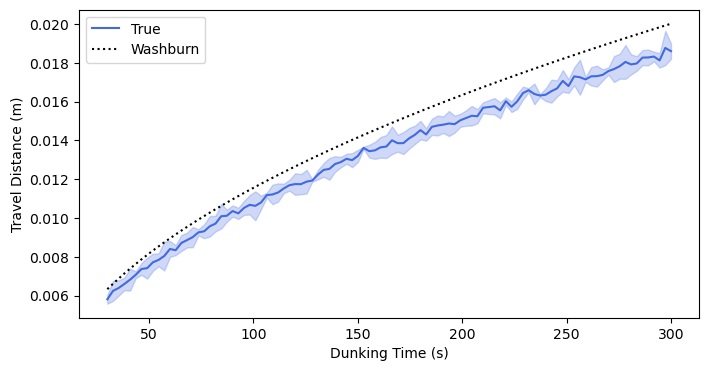

In [47]:
# Visualise the fit of the Washburn model.
comparison_plot(time_series_2, washburn_ts_2_predicted, ("True", "Washburn"))

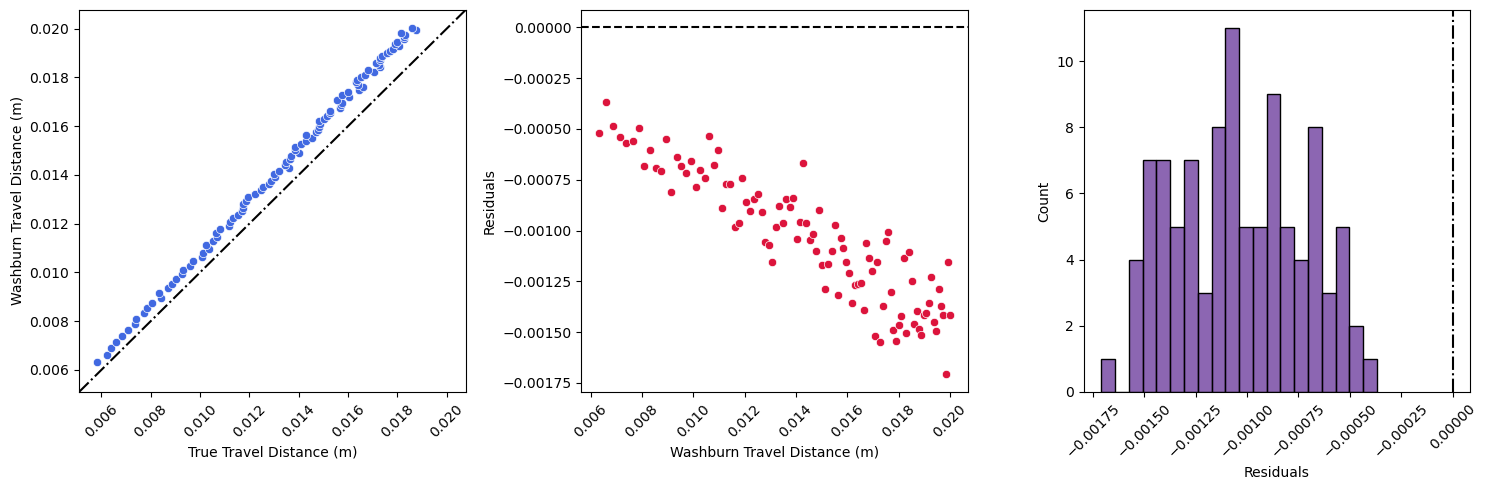

In [48]:
# Visualise the performance of the Washburn model.
performance_plot(time_series_2, washburn_ts_2_predicted, "Washburn Travel Distance (m)")

In [49]:
# Calculate the log-likelihood of the Washburn model.
washburn_ts_2_log_likelihood = ts_2_mvn.logpdf(washburn_ts_2_predicted)
print(f"Washburn TS-2 Log-Likelihood: {washburn_ts_2_log_likelihood}")

Washburn TS-2 Log-Likelihood: -319.4225793446602


In [50]:
# Calculate the MAE, MSE and RMSE of the Washburn model.
errors = error_metrics(time_series_2["travel-distance"], washburn_ts_2_predicted)
washburn_ts_2_mae, washburn_ts_2_mse, washburn_ts_2_rmse = errors

# Print the error metrics.
print(f"Washburn TS-2 MAE : {washburn_ts_2_mae:.5e}")
print(f"Washburn TS-2 MSE : {washburn_ts_2_mse:.5e}")
print(f"Washburn TS-2 RMSE: {washburn_ts_2_rmse:.5e}")

Washburn TS-2 MAE : 1.04029e-03
Washburn TS-2 MSE : 1.18007e-06
Washburn TS-2 RMSE: 1.08631e-03


In [51]:
# Calculate the R2 score of the Washburn model.
washburn_ts_2_r2 = r2_score(time_series_2["travel-distance"], washburn_ts_2_predicted)
print(f"Washburn TS-2 R2 Score: {washburn_ts_2_r2:.5f}")

Washburn TS-2 R2 Score: 0.90541


##### $\textbf{3.6.3 Modified Washburn Model}$

$$
L = \alpha \sqrt{\frac{\gamma r t \cos(\phi)}{2 \eta}} + \beta
$$

In [52]:
# Define the prior distribution for alpha and beta.
priors_ts_2  = [uniform(0, 10), uniform(0, 10)]

In [53]:
def prior_transform_ts_2(random_variables: np.ndarray):
    """
    Transforms random variables to model parameters. This is for the modified 
    Washburn model for the 2nd time series data.

    Parameters
    ----------
    random_variables : np.ndarray
        The random variables to transform.
    
    Returns
    -------
    list
        The model parameters.
    """
    
    return [p.ppf(u) for p, u in zip(priors_ts_2, random_variables)]

In [54]:
def log_likelihood_ts_2(parameters: np.ndarray):
    """
    Calculates the log-likelihood of the modified Washburn model for the 2nd 
    time series data.
    
    Parameters
    ----------
    parameters : np.ndarray
        The model parameters.

    Returns
    -------
    float
        The log-likelihood.
    """

    # Calculate the predicted values from the model.
    washburn_modified = washburn_modified_ts(alpha=parameters[0],
                                             beta=parameters[1],
                                             radius=pore_radius_mean["Rich Tea"], 
                                             time=time_series_2["dunking-time"])
    
    return ts_2_mvn.logpdf(washburn_modified)

In [55]:
# Perform nested sampling to find the optimal alpha and beta values.
sampler_ts_2 = ultranest.ReactiveNestedSampler(["alpha_ts_2", "beta_ts_2"], log_likelihood_ts_2, prior_transform_ts_2)
sampler_ts_2.run(show_status=True)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=7e+02  4 [657.2340..657.2340]*| it/evals=9280/12057 eff=79.6088% N=400  0 00  0   0   0        
[ultranest] Likelihood function evaluations: 12071
[ultranest]   logZ = 638.6 +- 0.1003
[ultranest] Effective samples strategy satisfied (ESS = 1499.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.


{'niter': 9691,
 'logz': np.float64(638.6159375737755),
 'logzerr': np.float64(0.16401671533250625),
 'logz_bs': np.float64(638.6192263850227),
 'logz_single': np.float64(638.6159375737755),
 'logzerr_tail': np.float64(0.009944000780137685),
 'logzerr_bs': np.float64(0.1637149955164432),
 'ess': np.float64(1499.197213035506),
 'H': np.float64(17.771792441129378),
 'Herr': np.float64(0.08896307088429978),
 'posterior': {'mean': [0.9200641365262641, 0.00013651653563515268],
  'stdev': [0.005828533034395179, 8.431814949959051e-05],
  'median': [0.9205555333269279, 0.0001252539384815506],
  'errlo': [0.9141349417375711, 4.8810414801377086e-05],
  'errup': [0.9259979224844406, 0.00022157324198463705],
  'information_gain_bits': [4.14647919764959, 4.14647919764959]},
 'weighted_samples': {'upoints': array([[1.85779181e-01, 9.96969091e-01],
         [6.22257389e-01, 9.89295737e-01],
         [1.82211351e-01, 9.94681166e-01],
         ...,
         [9.22653188e-02, 9.73833481e-06],
         [9

In [56]:
# Print the results from the nested sampling.
sampler_ts_2.print_results()


logZ = 638.616 +- 0.164
  single instance: logZ = 638.616 +- 0.211
  bootstrapped   : logZ = 638.619 +- 0.164
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    alpha_ts_2          : 0.8865│ ▁   ▁ ▁▁ ▁▁▁▁▁▁▁▁▂▂▄▄▄▅▆▇▇▆▇▇▇▆▅▃▂▁▁▁ │0.9358    0.9201 +- 0.0058
    beta_ts_2           : 0.000010│▅▄▆▅▆▆▇▅▆▅▅▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁       ▁ │0.000652    0.000137 +- 0.000084



In [57]:
# Store the alpha and beta values with the maximum log-likelihood.
alpha_ts_2, beta_ts_2 = sampler_ts_2.results["maximum_likelihood"]["point"]

# Print the alpha and beta values.
print(f"Alpha TS-2: {alpha_ts_2:.8f}")
print(f"Beta  TS-2: {beta_ts_2:.8f}")

Alpha TS-2: 0.92271539
Beta  TS-2: 0.00009646


In [58]:
# Predict the travel-distance using the modified Washburn model.
washburn_mod_ts_2_predicted = washburn_modified_ts(alpha=alpha_ts_2,
                                                   beta=beta_ts_2,
                                                   radius=pore_radius_mean["Rich Tea"], 
                                                   time=time_series_2["dunking-time"])

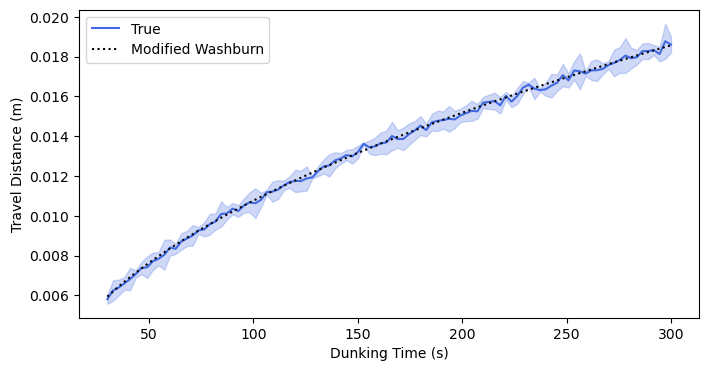

In [59]:
# Visualise the fit of the modified Washburn model.
comparison_plot(time_series_2, washburn_mod_ts_2_predicted, ("True", "Modified Washburn"))

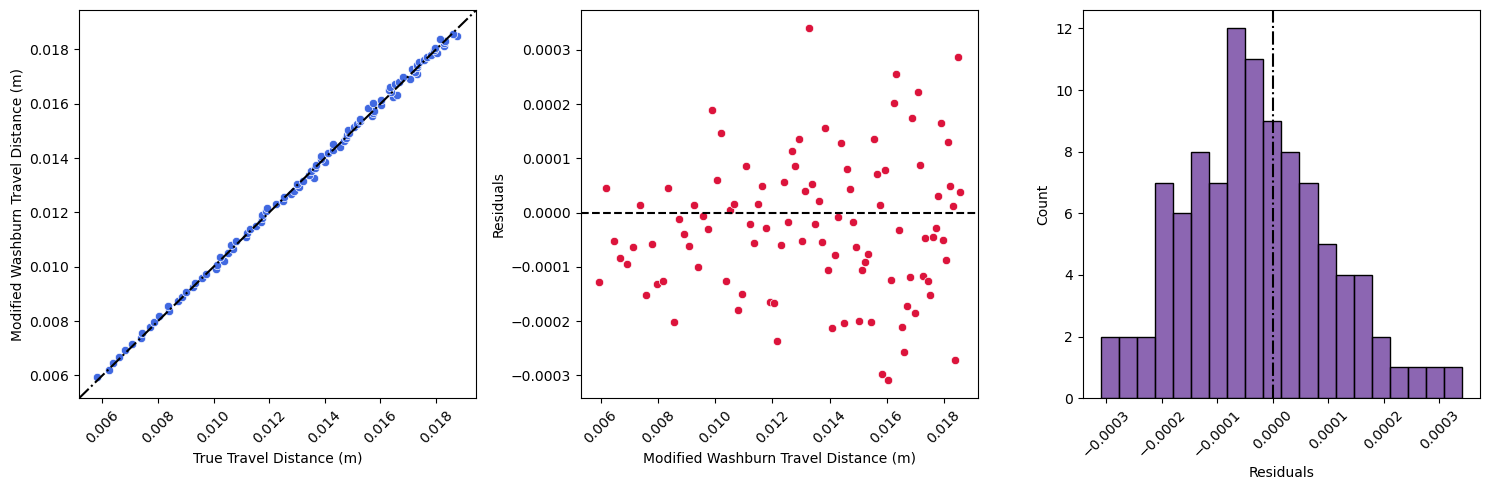

In [60]:
# Visualise the performance of the modifiedWashburn model.
performance_plot(time_series_2, washburn_mod_ts_2_predicted, "Modified Washburn Travel Distance (m)")

In [61]:
# Store the log-likelihood of the modified Washburn model.
washburn_mod_log_likelihood_ts_2 = sampler_ts_2.results["maximum_likelihood"]["logl"]
print(f"Modified Washburn TS-2 Log-Likelihood: {washburn_mod_log_likelihood_ts_2}")

Modified Washburn TS-2 Log-Likelihood: 657.2412874703948


In [62]:
# Calculate the MAE, MSE and RMSE of the modified Washburn model.
errors = error_metrics(time_series_2["travel-distance"], washburn_mod_ts_2_predicted)
washburn_mod_ts_2_mae, washburn_mod_ts_2_mse, washburn_mod_ts_2_rmse = errors

# Print the error metrics.
print(f"Modified Washburn TS-2 MAE : {washburn_mod_ts_2_mae:.5e}")
print(f"Modified Washburn TS-2 MSE : {washburn_mod_ts_2_mse:.5e}")
print(f"Modified Washburn TS-2 RMSE: {washburn_mod_ts_2_rmse:.5e}")

Modified Washburn TS-2 MAE : 1.05744e-04
Modified Washburn TS-2 MSE : 1.74278e-08
Modified Washburn TS-2 RMSE: 1.32014e-04


In [63]:
# Calculate the R2 score of the Washburn model.
washburn_mod_ts_2_r2 = r2_score(time_series_2["travel-distance"], washburn_mod_ts_2_predicted)
print(f"Modified Washburn TS-2 R2 Score: {washburn_mod_ts_2_r2:.5f}")

Modified Washburn TS-2 R2 Score: 0.99860


##### $\textbf{3.6.4 Model Comparison}$

In [64]:
# Print the R2 score of the different models.
print(f"Washburn TS-2 R2 Score          : {washburn_ts_2_r2:.5f}")
print(f"Modified Washburn TS-2 R2 Score : {washburn_mod_ts_2_r2:.5f}")

Washburn TS-2 R2 Score          : 0.90541
Modified Washburn TS-2 R2 Score : 0.99860


In [65]:
# Calculate the Bayes factor between the modified and normal Washburn model.
bayes_factor_ts_2 = sampler_ts_2.results["logz"] - washburn_ts_2_log_likelihood
print(f"Bayes Factor (Modified vs Original Washburn) TS-2: {bayes_factor_ts_2}")

Bayes Factor (Modified vs Original Washburn) TS-2: 958.0385169184357


#### $\textbf{3.7 Time Series Data 3 - Digestive Biscuit}$

##### $\textbf{3.7.1 Data Modelling}$

In [66]:
# Create a diagonal covariance matrix.
ts_3_covariance = np.diag(time_series_3["travel-distance-error"] ** 2)

# Generate a multivariate normal distribution.
ts_3_mvn = multivariate_normal(time_series_3["travel-distance"], ts_3_covariance)

##### $\textbf{3.7.2 Washburn Model}$

In [67]:
# Predict the travel-distance using the Washburn model.
washburn_ts_3_predicted = washburn_ts(pore_radius_mean["Digestive"], time_series_3["dunking-time"])

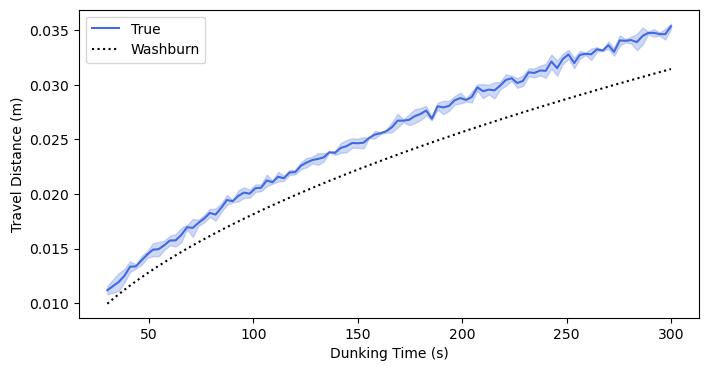

In [68]:
# Visualise the fit of the Washburn model.
comparison_plot(time_series_3, washburn_ts_3_predicted, ("True", "Washburn"))

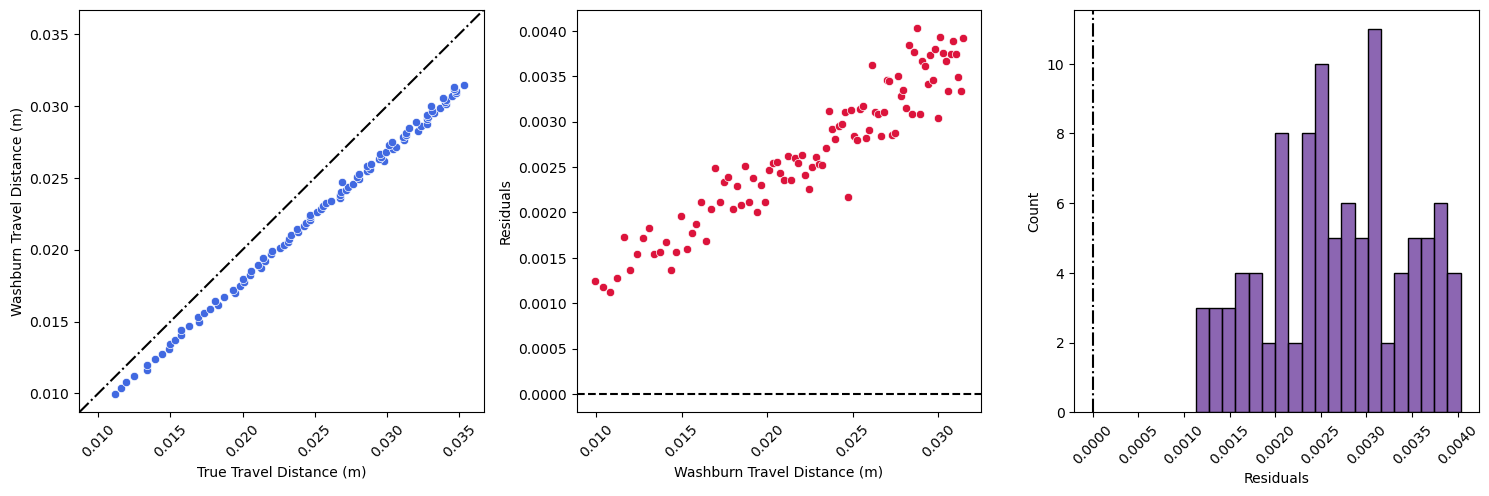

In [69]:
# Visualise the performance of the Washburn model.
performance_plot(time_series_3, washburn_ts_3_predicted, "Washburn Travel Distance (m)")

In [70]:
# Calculate the log-likelihood of the Washburn model.
washburn_ts_3_log_likelihood = ts_3_mvn.logpdf(washburn_ts_3_predicted)
print(f"Washburn TS-3 Log-Likelihood: {washburn_ts_3_log_likelihood}")

Washburn TS-3 Log-Likelihood: -111522.13712396938


In [71]:
# Calculate the MAE, MSE and RMSE of the Washburn model.
errors = error_metrics(time_series_3["travel-distance"], washburn_ts_3_predicted)
washburn_ts_3_mae, washburn_ts_3_mse, washburn_ts_3_rmse = errors

# Print the error metrics.
print(f"Washburn TS-3 MAE : {washburn_ts_3_mae:.5e}")
print(f"Washburn TS-3 MSE : {washburn_ts_3_mse:.5e}")
print(f"Washburn TS-3 RMSE: {washburn_ts_3_rmse:.5e}")

Washburn TS-3 MAE : 2.67598e-03
Washburn TS-3 MSE : 7.72027e-06
Washburn TS-3 RMSE: 2.77854e-03


In [72]:
# Calculate the R2 score of the Washburn model.
washburn_ts_3_r2 = r2_score(time_series_3["travel-distance"], washburn_ts_3_predicted)
print(f"Washburn TS-3 R2 Score: {washburn_ts_3_r2:.5f}")

Washburn TS-3 R2 Score: 0.82845


##### $\textbf{3.7.3 Modified Washburn Model}$

$$
L = \alpha \sqrt{\frac{\gamma r t \cos(\phi)}{2 \eta}} + \beta
$$

In [73]:
# Define the prior distribution for alpha and beta.
priors_ts_3  = [uniform(0, 10), uniform(0, 10)]

In [74]:
def prior_transform_ts_3(random_variables: np.ndarray):
    """
    Transforms random variables to model parameters. This is for the modified 
    Washburn model for the 3rd time series data.

    Parameters
    ----------
    random_variables : np.ndarray
        The random variables to transform.
    
    Returns
    -------
    list
        The model parameters.
    """
    
    return [p.ppf(u) for p, u in zip(priors_ts_3, random_variables)]

In [75]:
def log_likelihood_ts_3(parameters: np.ndarray):
    """
    Calculates the log-likelihood of the modified Washburn model for the 3rd 
    time series data.
    
    Parameters
    ----------
    parameters : np.ndarray
        The model parameters.

    Returns
    -------
    float
        The log-likelihood.
    """

    # Calculate the predicted values from the model.
    washburn_modified = washburn_modified_ts(alpha=parameters[0],
                                             beta=parameters[1],
                                             radius=pore_radius_mean["Digestive"], 
                                             time=time_series_3["dunking-time"])
    
    return ts_3_mvn.logpdf(washburn_modified)

In [76]:
# Perform nested sampling to find the optimal alpha and beta values.
sampler_ts_3 = ultranest.ReactiveNestedSampler(["alpha_ts_3", "beta_ts_3"], log_likelihood_ts_3, prior_transform_ts_3)
sampler_ts_3.run(show_status=True)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=5e+02  5 [461.6441..461.6441]*| it/evals=10000/13123 eff=78.5978% N=400  00   0   0  0   0 0   
[ultranest] Likelihood function evaluations: 13168
[ultranest]   logZ = 441.2 +- 0.1664
[ultranest] Effective samples strategy satisfied (ESS = 1613.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.13 to 0.54, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.


{'niter': 10427,
 'logz': np.float64(441.18706649086346),
 'logzerr': np.float64(0.5393498893410223),
 'logz_bs': np.float64(441.1657606026244),
 'logz_single': np.float64(441.18706649086346),
 'logzerr_tail': np.float64(0.009942540273698341),
 'logzerr_bs': np.float64(0.5392582396450507),
 'ess': np.float64(1613.8892446645425),
 'H': np.float64(19.463826333086388),
 'Herr': np.float64(0.15721770144415312),
 'posterior': {'mean': [1.0948665540938942, 0.0005470468835294479],
  'stdev': [0.0027186329815468515, 5.9890579178234815e-05],
  'median': [1.0948151187899362, 0.000547845607655049],
  'errlo': [1.0923343783306887, 0.0004872347928828399],
  'errup': [1.0976127692365067, 0.0006042401850447977],
  'information_gain_bits': [4.14647919764959, 4.14647919764959]},
 'weighted_samples': {'upoints': array([[7.95466751e-01, 9.98343490e-01],
         [6.02862103e-01, 9.97173305e-01],
         [7.29872721e-01, 9.87617209e-01],
         ...,
         [1.09486705e-01, 5.47028230e-05],
         [

In [77]:
# Print the results from the nested sampling.
sampler_ts_3.print_results()


logZ = 441.187 +- 0.539
  single instance: logZ = 441.187 +- 0.221
  bootstrapped   : logZ = 441.166 +- 0.539
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    alpha_ts_3          : 1.0831│ ▁▁▁▁▁▁▁▁▁▂▂▂▃▄▅▇▇▇▇▆▆▅▄▄▂▂▁▁▁▁▁▁▁▁  ▁ │1.1073    1.0949 +- 0.0027
    beta_ts_3           : 0.000275│ ▁  ▁▁▁▁▁▁▁▂▂▃▃▅▅▅▆▇▇▇▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁ │0.000804    0.000547 +- 0.000060



In [78]:
# Store the alpha and beta values with the maximum log-likelihood.
alpha_ts_3, beta_ts_3 = sampler_ts_3.results["maximum_likelihood"]["point"]

# Print the alpha and beta values.
print(f"Alpha TS-3: {alpha_ts_3:.8f}")
print(f"Beta  TS-3: {beta_ts_3:.8f}")

Alpha TS-3: 1.09487434
Beta  TS-3: 0.00054685


In [79]:
# Predict the travel-distance using the modified Washburn model.
washburn_mod_ts_3_predicted = washburn_modified_ts(alpha=alpha_ts_3,
                                                   beta=beta_ts_3,
                                                   radius=pore_radius_mean["Digestive"], 
                                                   time=time_series_3["dunking-time"])

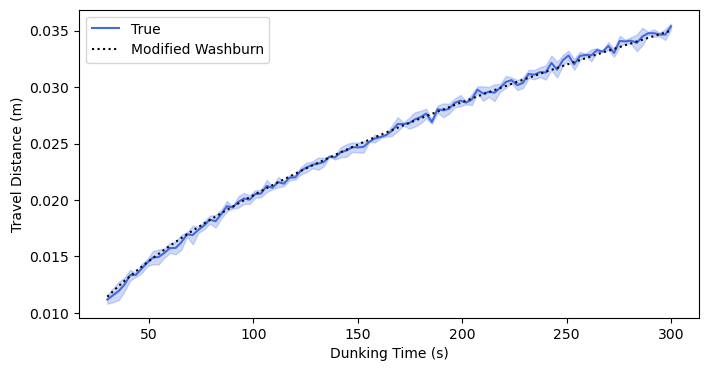

In [80]:
# Visualise the fit of the modified Washburn model.
comparison_plot(time_series_3, washburn_mod_ts_3_predicted, ("True", "Modified Washburn"))

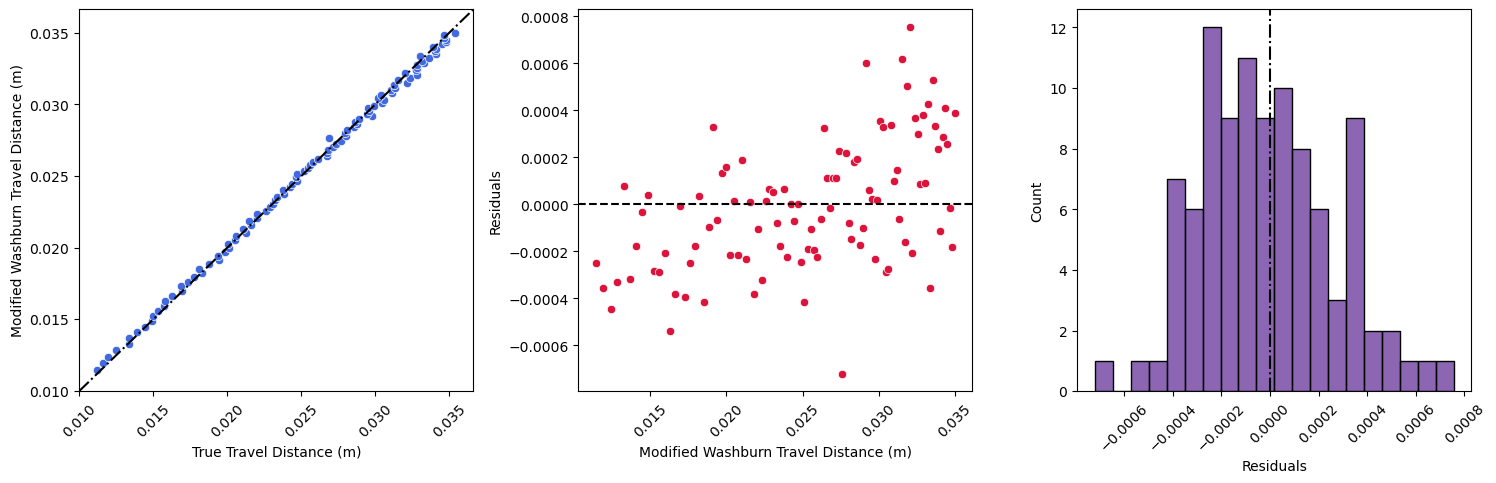

In [81]:
# Visualise the performance of the modifiedWashburn model.
performance_plot(time_series_3, washburn_mod_ts_3_predicted, "Modified Washburn Travel Distance (m)")

In [82]:
# Store the log-likelihood of the modified Washburn model.
washburn_mod_log_likelihood_ts_3 = sampler_ts_3.results["maximum_likelihood"]["logl"]
print(f"Modified Washburn TS-3 Log-Likelihood: {washburn_mod_log_likelihood_ts_3}")

Modified Washburn TS-3 Log-Likelihood: 461.65285419990096


In [83]:
# Calculate the MAE, MSE and RMSE of the modified Washburn model.
errors = error_metrics(time_series_3["travel-distance"], washburn_mod_ts_3_predicted)
washburn_mod_ts_3_mae, washburn_mod_ts_3_mse, washburn_mod_ts_3_rmse = errors

# Print the error metrics.
print(f"Modified Washburn TS-3 MAE : {washburn_mod_ts_3_mae:.5e}")
print(f"Modified Washburn TS-3 MSE : {washburn_mod_ts_3_mse:.5e}")
print(f"Modified Washburn TS-3 RMSE: {washburn_mod_ts_3_rmse:.5e}")

Modified Washburn TS-3 MAE : 2.21838e-04
Modified Washburn TS-3 MSE : 7.56490e-08
Modified Washburn TS-3 RMSE: 2.75044e-04


In [84]:
# Calculate the R2 score of the Washburn model.
washburn_mod_ts_3_r2 = r2_score(time_series_3["travel-distance"], washburn_mod_ts_3_predicted)
print(f"Modified Washburn TS-3 R2 Score: {washburn_mod_ts_3_r2:.5f}")

Modified Washburn TS-3 R2 Score: 0.99832


##### $\textbf{3.7.4 Model Comparison}$

In [85]:
# Print the R2 score of the different models.
print(f"Washburn TS-3 R2 Score          : {washburn_ts_3_r2:.5f}")
print(f"Modified Washburn TS-3 R2 Score : {washburn_mod_ts_3_r2:.5f}")

Washburn TS-3 R2 Score          : 0.82845
Modified Washburn TS-3 R2 Score : 0.99832


In [86]:
# Calculate the Bayes factor between the modified and normal Washburn model.
bayes_factor_ts_3 = sampler_ts_3.results["logz"] - washburn_ts_3_log_likelihood
print(f"Bayes Factor (Modified vs Original Washburn) TS-3: {bayes_factor_ts_3}")

Bayes Factor (Modified vs Original Washburn) TS-3: 111963.32419046025


#### $\textbf{3.8 Model Comparison}$

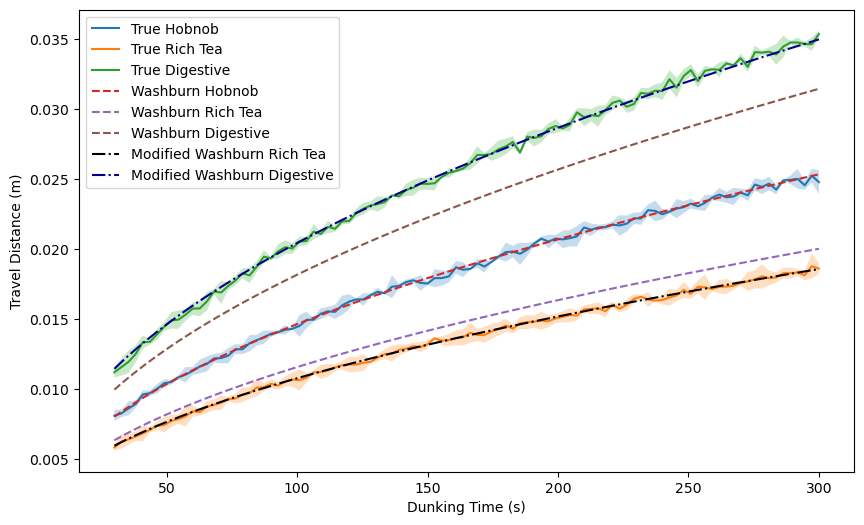

In [87]:
# Visualise the performance of the different models on the time series data.
fig, ax = plt.subplots(figsize=(10, 6))

# Set labels for the plots.
labels = ("Hobnob", "Rich Tea", "Digestive")

# Collect the time series data.
time_series_data = (time_series_1, time_series_2, time_series_3)

# Plot the time series data.
for time_series, label in zip(time_series_data, labels):
    # Plot the data.
    ax.plot(time_series["dunking-time"], 
            time_series["travel-distance"], 
            label=f"True {label}")
    
    # Plot the errors.
    ax.fill_between(time_series["dunking-time"], 
                    time_series["travel-distance"] - time_series["travel-distance-error"],
                    time_series["travel-distance"] + time_series["travel-distance-error"],
                    alpha=0.25)

# Collect the Washburn predicted data.
washburn_data = (washburn_ts_1_predicted, washburn_ts_2_predicted, washburn_ts_3_predicted)

# Plot the Washburn predicted data.
for time_series, washburn, label in zip(time_series_data, washburn_data, labels):
    # Plot the data.
    ax.plot(time_series["dunking-time"], 
            washburn,
            linestyle="--", 
            label=f"Washburn {label}")

# Plot the modified Washburn predicted data for the 2nd time series data.
ax.plot(time_series_2["dunking-time"], 
        washburn_mod_ts_2_predicted, 
        linestyle="-.",
        color="black",
        label="Modified Washburn Rich Tea")

# Plot the modified Washburn predicted data for the 3rd time series data.
ax.plot(time_series_3["dunking-time"], 
        washburn_mod_ts_3_predicted, 
        linestyle="-.",
        color="darkblue",
        label="Modified Washburn Digestive")

# Set the legend.
ax.legend()

# Set the labels.
ax.set_xlabel("Dunking Time (s)")
ax.set_ylabel("Travel Distance (m)")

plt.show()